# **Lab 2: Linear Regression**

---
NOTE: This is a lab project accompanying the following book [MLF] and it should be used together with the book.

[MLF] *H. Jiang*, "[Machine Learning Fundamentals: A Concise Introduction](http://wiki.eecs.yorku.ca/user/hj/research:mlfbook)", Cambridge University Press, 2021.  ([bibtex](http://www.cse.yorku.ca/~hj/mlf-jiang.bib))

---


The purpose of this lab is to apply a simple machine learning method, namely *linear regression*, to some regression and classification tasks on two popular data sets. We will show how linear regression may differ when used to solve a regression or classification problem. As we know, linear regression is simple enough so that we can derive the closed-form solution to solve it. In this project, we will use both the closed-form method and an iterative gradient descent method (e.g. minibatch SGD) to solve linear regression for these tasks and compare their pros and cons in practice. Moreover, we will use linear regression as a simple example to explain some fine-tuning tricks when using any iterative optimization methods (e.g. SGD) in machine learning. As we will see in the up-coming projects, these tricks become vital in learning large models in machine learning, such as deep neural networks. 

*Prerequisites*: N/A

## **I. Linear Regression for Regression**


### **Example 2.1:**

Use linear regression to predict house prices in the popular [Boston House data set](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). Consider to use both the closed-form solution and an iterative method to fit to the data and discuss their pros and cons with some experimental results. 

In [ ]:
#link my Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load Boston House data set
import pandas as pd
import numpy as np

raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/boston.csv', header=None)
data_rows = np.reshape(raw_data.to_numpy(), (506,14))
data = data_rows[:,:13]
target = data_rows[:,13]

# normalize input features to zero-mean and unit-variance
data = (data-np.mean(data, axis=0))/np.std(data, axis=0) 

print(data.shape)
print(target.shape)

(506, 13)
(506,)


In [ ]:
# use the closed-form solution (Eq(6.9) on page 112)

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))

print(data_wb.shape)

# refer to the closed-form solution, i.e. Eq.(6.9) on page 112
w = np.linalg.inv(data_wb.T @ data_wb) @ data_wb.T @ target

# calculate the mean square error in the training set
predict = data_wb @ w 
error = np.sum((predict - target)*(predict - target))/data.shape[0]

print(f'mean square error for the closed-form solution: {error:.5f}')

(506, 14)
mean square error for the closed-form solution: 21.89483


Consider to solve the above linear regression using an iterative optimization, such as gradient descent.

Refer to eq.(6.8) on page 112, the objective function in linear regression, i.e. the mean square error (MSE), is given as:
\begin{eqnarray}
E(\mathbf{w}) & = & \frac{1}{2} \sum_{i=1}^N \big( \mathbf{w}^\intercal \mathbf{x}_i - y_i \big)^2  \nonumber \\
& = & \frac{1}{2} \Big(
\mathbf{w}^\intercal \mathbf{X}^\intercal \mathbf{X} \mathbf{w} - 2 \mathbf{w}^\intercal  \mathbf{X} ^\intercal  \mathbf{y} + \mathbf{y}^\intercal \mathbf{y} \Big)\nonumber
\end{eqnarray}
we can show that its gradient can be computed in several equivallent ways as follows:
\begin{eqnarray}
\frac{\partial E(\mathbf{w})}{ \partial \mathbf{w} } 
& = & \sum_{i=1}^ N  \big( \mathbf{w}^\intercal \mathbf{x}_i - y_i \big) \mathbf{x}_i 
= \sum_{i=1}^ N  \mathbf{x}_i  \big( \mathbf{x}_i^\intercal \mathbf{w} - y_i \big) 
\nonumber \\
& = & \Big( \sum_{i=1}^N  \mathbf{x}_i \mathbf{x}_i^ \intercal \Big) \mathbf{w} - \sum_{i=1}^N  y_i \mathbf{x}_i \nonumber \\
& = &  \mathbf{X}^\intercal \mathbf{X} \mathbf{w} - \mathbf{X} ^\intercal  \mathbf{y}
\end{eqnarray}
where $\mathbf{X}$ and $\mathbf{y}$ are defined in the same way as on page 112. 

In the following, we use the formula from last row to calculate gradients via vectorization. Furthermore, we  implement a mini-batch SGD, .i.e. **Algorithm 2.3** on page 62, to learn linear regression iteratively. 

In [ ]:
# solve linear regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer 
def linear_regression_gd(X, y, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errors = np.zeros(op.max_epochs)
  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= lr * w_grad / X_batch.shape[0]

    diff = X @ w - y  # prediction difference
    errors[epoch] = np.sum(diff*diff)/n
    lr *= op.annealing_rate
    #print(f'epoch={epoch}: the mean square error is {errors[epoch]}')

  return w, errors

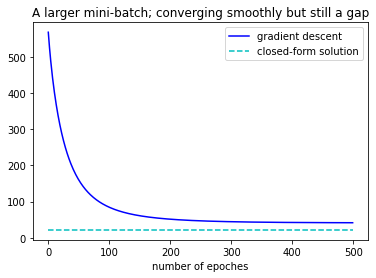

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('A larger mini-batch; converging smoothly but still a gap')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

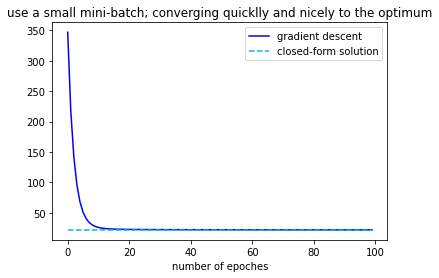

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=2, max_epochs=100)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('use a small mini-batch; converging quicklly and nicely to the optimum')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

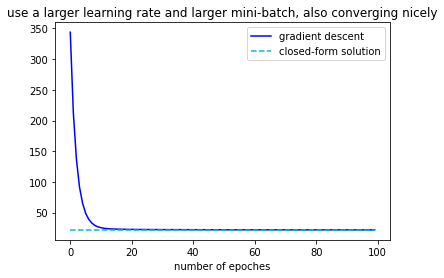

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.01, annealing_rate=0.99, batch_size=20, max_epochs=100)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('use a larger learning rate and larger mini-batch, also converging nicely')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

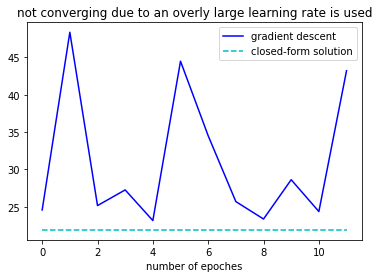

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.2, annealing_rate=0.99, batch_size=20, max_epochs=12)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('not converging due to an overly large learning rate is used')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

Finally, let us show how to solve the above linear regression problem using the scikit-learning implmenetation. 

In [ ]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create linear regression object
l_regr = linear_model.LinearRegression()

# Train the model using the training set
l_regr.fit(data_wb, target)

# Make predictions using the same training set
predict = l_regr.predict(data_wb)

# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(target, predict))

Mean squared error: 21.89483


## **II. Linear Regression for Classification**

### **Example 2.2:**

Use linear regression to build a binary classifier to classify two digits ('3' and '8') in the MNIST data set. Consider to use both the closed-form solution and an iterative method to fit to the data and discuss their pros and cons with experimental results.

In [ ]:
# install python_mnist

!pip install python_mnist

In [ ]:
#load MINST images

from mnist import MNIST
import numpy as np

mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape) 

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [ ]:
# prepare digits '3' and '8' for linear regression

digit_train_index = np.logical_or(train_label == 3, train_label == 8)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 3, test_label == 8)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# convert labels: '3' => -1, '8' => +1
CUTOFF = 5 # any number between '3' and '8'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

print(X_train.shape)
print(y_train)

print(X_test.shape)
print(y_test)

(11982, 784)
[-1 -1 -1 ...  1 -1  1]
(1984, 784)
[-1 -1 -1 ... -1  1 -1]


In [ ]:
# use the closed-form solution

# refer to the closed-form solution, i.e. Eq.(6.9) on page 112
w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# calculate the mean square error and classification accuracy on the training set
predict = X_train @ w 
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w 
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

mean square error on training data for the closed-form solution: 0.19629
classification accuracy on training data for the closed-form solution: 96.99%
mean square error on training data for the closed-form solution: 1.30940
classification accuracy on test data for the closed-form solution: 95.92%


In [ ]:
# use linear regression from sklearn

import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create linear regression object
l_regr = linear_model.LinearRegression()

# Train the model using the training set
l_regr.fit(X_train, y_train)

# Make predictions using the same training set
predict = l_regr.predict(X_train)
print("Mean squared error on training data: %.5f" % mean_squared_error(y_train, predict))

# Make predictions using the test set
predict = l_regr.predict(X_test)
print("Mean squared error on test data: %.5f" % mean_squared_error(y_test, predict))

Mean squared error on training data: 0.19629
Mean squared error on test data: 1.30940


Next, let us consider to use mini-batch stochastic gradient descent (SGD) to learn linear regression models for this binary classification problem. When we fine-tune any SGD method for a classificaion problem in machline learning, it is very important to monitor the following three learning curves:

1.   *Classification Accuracy on the training set* (**curve A**): this is the goal of the empirical risk mininization (ERM) of the zero-one loss for classification (see Eq.(5.6) on page 99).  

2.  *Classification Accuracy on an unseen test/development set* (**curve B**): we need to compare the curves **A** and **B** over the learning course to monitor whether overfitting or underfit occurs. Overfitting happens when the gap between **A** and **B** is overly big while underfitting happens when **A** and **B** get very close and both of them yield fairly poor performance. Moreover, we can also monitor the curves  **A** and **B**  to determine when to terminate the learning proces for the best possible performance on the test/devopement set. 

3.  *The value of the learning objective function* (**curve C**): because the zero-one loss is not directly minimizable, we will have to establish a proxy objective function according to some criteria (see Tabe 7.1 on page 135). These objective functions are closelly related to the zero-one loss but they are NOT the same. When we fine-tune an iterative optimization method, the first thing is to ensure that the value of the chosen objective function descreases over the entire learning course. If we cannot reduce the objective function (even when a sufficiently small learning rate is used), it is very likely that the implementation or code is buggy. Furthermore, if curve **C** is going down while curve **A** is not going up, this is another indicator that someting is still wrong in the implementation. 


In [ ]:
# solve linear regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def linear_regression_gd2(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= lr * w_grad / X_batch.shape[0] 

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n   

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC

epoch=0: the mean square error is 0.398 (0.911,0.920)
epoch=1: the mean square error is 0.309 (0.929,0.942)
epoch=2: the mean square error is 0.279 (0.938,0.950)
epoch=3: the mean square error is 0.264 (0.945,0.957)
epoch=4: the mean square error is 0.254 (0.949,0.959)
epoch=5: the mean square error is 0.248 (0.951,0.962)
epoch=6: the mean square error is 0.244 (0.953,0.961)
epoch=7: the mean square error is 0.240 (0.954,0.962)
epoch=8: the mean square error is 0.237 (0.955,0.964)
epoch=9: the mean square error is 0.235 (0.956,0.963)
epoch=10: the mean square error is 0.234 (0.957,0.963)
epoch=11: the mean square error is 0.232 (0.957,0.964)
epoch=12: the mean square error is 0.231 (0.958,0.964)
epoch=13: the mean square error is 0.230 (0.958,0.964)
epoch=14: the mean square error is 0.229 (0.958,0.964)
epoch=15: the mean square error is 0.228 (0.959,0.964)
epoch=16: the mean square error is 0.227 (0.959,0.962)
epoch=17: the mean square error is 0.226 (0.959,0.963)
epoch=18: the mean s

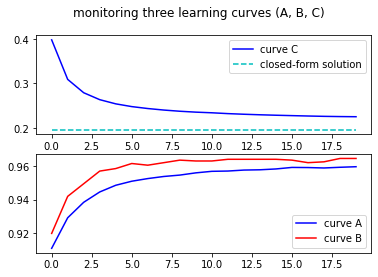

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20)

w, A, B, C = linear_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

In the above setting, we use a large mini-batch (50), which leads to fairly smooth convergence. As we can see, even though there is a big gap in the objective function between SGD (curve C) and the closed-form solution, classification accuracy of SGD  exceeds that of the closed-form solution on either the training or  testing set. This indicates that MSE used in linear regression is NOT a good learning criterion for classification (see why in section 7.1.1 on page 136).

epoch=0: the mean square error is 0.236 (0.956,0.963)
epoch=1: the mean square error is 0.224 (0.960,0.964)
epoch=2: the mean square error is 0.220 (0.961,0.963)
epoch=3: the mean square error is 0.217 (0.962,0.964)
epoch=4: the mean square error is 0.215 (0.962,0.963)
epoch=5: the mean square error is 0.214 (0.963,0.963)
epoch=6: the mean square error is 0.213 (0.964,0.965)
epoch=7: the mean square error is 0.215 (0.963,0.962)
epoch=8: the mean square error is 0.212 (0.963,0.964)
epoch=9: the mean square error is 0.214 (0.963,0.963)


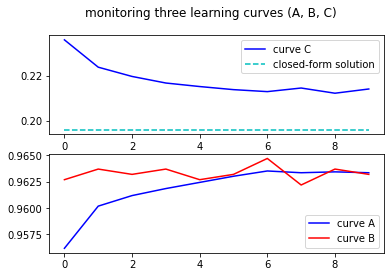

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=5, max_epochs=10)

w, A, B, C = linear_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

In this setting, we use the same learning rate but a much smaller mini-batch size. A smaller mini-batch means more model updates in each epoch. As a result, the classification accuracy on the training set (curve **A**) is improved over the previous setting. However, we can see that the classification accuracy on the unseen set (curve **B**) starts to go down after epoch 6, which indicates that we should terminate the learning at epoch 6. 

## **Exercises**

### **Problem 2.1:**

Use Ridge regression to solve the regression problem in Example 2.1 as well as the classification problem in Example 2.2, also implement both closed-form and iterative approachs, compare the results of Ridge regression with those of linear regression.

### **Problem 2.2:**

Use LASSO to solve the regression problem in Example 2.1 as well as the classification problem in Example 2.2, compare the results of LASSO with those of linear regression and Ridge regression.